In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-02-02 15:12:07.423199: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import random

random.seed(10)
print(random.random())

0.5714025946899135


In [4]:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/#climate-data-timeseries
data = pd.read_csv("../../data/jena_climate_2009_2016_hourly.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


In [5]:
data.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

(array([1.0110e+03, 9.2470e+03, 1.5193e+04, 1.2302e+04, 9.8740e+03,
        7.9000e+03, 5.3950e+03, 3.5180e+03, 2.1770e+03, 1.3350e+03,
        8.5000e+02, 5.1000e+02, 2.9700e+02, 2.1200e+02, 1.2200e+02,
        9.7000e+01, 4.4000e+01, 2.8000e+01, 1.2000e+01, 5.0000e+00]),
 array([ 0.        ,  3.14716667,  6.29433333,  9.4415    , 12.58866667,
        15.73583333, 18.883     , 22.03016667, 25.17733333, 28.3245    ,
        31.47166667, 34.61883333, 37.766     , 40.91316667, 44.06033333,
        47.2075    , 50.35466667, 53.50183333, 56.649     , 59.79616667,
        62.94333333]),
 <BarContainer object of 20 artists>)

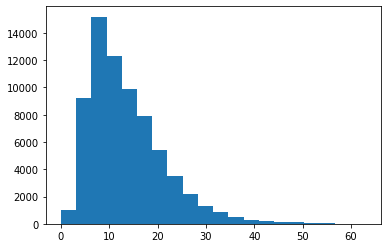

In [6]:
plt.hist(data['VPmax (mbar)'], bins=20)

In [7]:
print(data['VPmax (mbar)'].min())
print(data['VPmax (mbar)'].max())

0.0
62.94333333333333


In [8]:
np.percentile(data['VPmax (mbar)'], 95)

28.333666666666637

### Preprocess

In [9]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (70046, 1176)


In [10]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 5
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 1008) (49032, 12) (10507, 1008) (10507, 12) (10507, 1008) (10507, 12)


In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 72, 14) (49032, 12) (10507, 72, 14) (10507, 12) (10507, 72, 14) (10507, 12)


### Pressure threshold

In [12]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(49032,)
(10507,)
(10507,)


In [13]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.48441203148316114


### train_X_filter

In [14]:
train_X_extreme = train_X[train_X_pm > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_y[train_X_pm > percentile_pm]
print(train_y_extreme.shape)

(2206, 72, 14)
(2206, 12)


In [15]:
train_X_normal = train_X[train_X_pm <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_y[train_X_pm <= percentile_pm]
print(train_y_normal.shape)

(46826, 72, 14)
(46826, 12)


### val_X_filter

In [16]:
val_X_extreme = val_X[val_X_pm > percentile_pm]
print(val_X_extreme.shape)

val_y_extreme = val_y[val_X_pm > percentile_pm]
print(val_y_extreme.shape)

(486, 72, 14)
(486, 12)


In [17]:
val_X_normal = val_X[val_X_pm <= percentile_pm]
print(val_X_normal.shape)

val_y_normal = val_y[val_X_pm <= percentile_pm]
print(val_y_normal.shape)

(10021, 72, 14)
(10021, 12)


### test_X_filter

In [18]:
test_X_extreme = test_X[test_X_pm > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_y[test_X_pm > percentile_pm]
print(test_y_extreme.shape)

(811, 72, 14)
(811, 12)


In [19]:
test_X_normal = test_X[test_X_pm <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_y[test_X_pm <= percentile_pm]
print(test_y_normal.shape)

(9696, 72, 14)
(9696, 12)


### Model & training

In [24]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0  # 0.1
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [25]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [26]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
#                                                           decay_steps=decay_steps,
#                                                           decay_rate=decay_rate)

# model.compile(optimizer=Adam(learning_rate=lr_schedule),
#               loss='mse',
#               metrics=['mae']
#              )

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models_mlp/pressure_E.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X_extreme, train_y_extreme,
          validation_data=(val_X_extreme, val_y_extreme),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/1000
5/5 - 3s - loss: 0.1036 - mae: 0.2786 - val_loss: 0.0592 - val_mae: 0.2011

Epoch 00001: val_mae improved from inf to 0.20115, saving model to ../../saved_models_mlp/pressure_E.h5
Epoch 2/1000
5/5 - 0s - loss: 0.0515 - mae: 0.1737 - val_loss: 0.0616 - val_mae: 0.2268

Epoch 00002: val_mae did not improve from 0.20115
Epoch 3/1000
5/5 - 0s - loss: 0.0240 - mae: 0.1249 - val_loss: 0.0167 - val_mae: 0.1038

Epoch 00003: val_mae improved from 0.20115 to 0.10378, saving model to ../../saved_models_mlp/pressure_E.h5
Epoch 4/1000
5/5 - 0s - loss: 0.0225 - mae: 0.1134 - val_loss: 0.0353 - val_mae: 0.1644

Epoch 00004: val_mae did not improve from 0.10378
Epoch 5/1000
5/5 - 0s - loss: 0.0201 - mae: 0.1119 - val_loss: 0.0141 - val_mae: 0.0956

Epoch 00005: val_mae improved from 0.10378 to 0.09558, saving model to ../../saved_models_mlp/pressure_E.h5
Epoch 6/1000
5/5 - 0s - loss: 0.0168 - mae: 0.0980 - val_loss: 0.0158 - val_mae: 0.1058

Epoch 00006: val_mae did not improve from 0.09

Epoch 57/1000
5/5 - 0s - loss: 0.0034 - mae: 0.0417 - val_loss: 0.0070 - val_mae: 0.0645

Epoch 00057: val_mae did not improve from 0.06231
Epoch 58/1000
5/5 - 0s - loss: 0.0034 - mae: 0.0417 - val_loss: 0.0064 - val_mae: 0.0624

Epoch 00058: val_mae did not improve from 0.06231
Epoch 59/1000
5/5 - 0s - loss: 0.0033 - mae: 0.0416 - val_loss: 0.0070 - val_mae: 0.0651

Epoch 00059: val_mae did not improve from 0.06231
Epoch 60/1000
5/5 - 0s - loss: 0.0035 - mae: 0.0425 - val_loss: 0.0064 - val_mae: 0.0626

Epoch 00060: val_mae did not improve from 0.06231
Epoch 61/1000
5/5 - 0s - loss: 0.0035 - mae: 0.0428 - val_loss: 0.0064 - val_mae: 0.0634

Epoch 00061: val_mae did not improve from 0.06231
Epoch 62/1000
5/5 - 0s - loss: 0.0035 - mae: 0.0426 - val_loss: 0.0068 - val_mae: 0.0663

Epoch 00062: val_mae did not improve from 0.06231
Epoch 63/1000
5/5 - 0s - loss: 0.0035 - mae: 0.0428 - val_loss: 0.0064 - val_mae: 0.0629

Epoch 00063: val_mae did not improve from 0.06231
Epoch 64/1000
5/5 - 


Epoch 00114: val_mae did not improve from 0.06156
Epoch 115/1000
5/5 - 0s - loss: 0.0026 - mae: 0.0365 - val_loss: 0.0075 - val_mae: 0.0707

Epoch 00115: val_mae did not improve from 0.06156
Epoch 116/1000
5/5 - 0s - loss: 0.0027 - mae: 0.0369 - val_loss: 0.0088 - val_mae: 0.0772

Epoch 00116: val_mae did not improve from 0.06156
Epoch 117/1000
5/5 - 0s - loss: 0.0027 - mae: 0.0369 - val_loss: 0.0110 - val_mae: 0.0882

Epoch 00117: val_mae did not improve from 0.06156
Epoch 118/1000
5/5 - 0s - loss: 0.0027 - mae: 0.0377 - val_loss: 0.0109 - val_mae: 0.0871

Epoch 00118: val_mae did not improve from 0.06156
Epoch 119/1000
5/5 - 0s - loss: 0.0027 - mae: 0.0373 - val_loss: 0.0085 - val_mae: 0.0762

Epoch 00119: val_mae did not improve from 0.06156
Epoch 120/1000
5/5 - 0s - loss: 0.0027 - mae: 0.0369 - val_loss: 0.0072 - val_mae: 0.0688

Epoch 00120: val_mae did not improve from 0.06156
Epoch 121/1000
5/5 - 0s - loss: 0.0027 - mae: 0.0377 - val_loss: 0.0078 - val_mae: 0.0727

Epoch 00121:

5/5 - 0s - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0087 - val_mae: 0.0767

Epoch 00173: val_mae did not improve from 0.06156
Epoch 174/1000
5/5 - 0s - loss: 0.0023 - mae: 0.0344 - val_loss: 0.0073 - val_mae: 0.0692

Epoch 00174: val_mae did not improve from 0.06156
Epoch 175/1000
5/5 - 0s - loss: 0.0025 - mae: 0.0360 - val_loss: 0.0076 - val_mae: 0.0709

Epoch 00175: val_mae did not improve from 0.06156
Epoch 176/1000
5/5 - 0s - loss: 0.0024 - mae: 0.0348 - val_loss: 0.0077 - val_mae: 0.0719

Epoch 00176: val_mae did not improve from 0.06156
Epoch 177/1000
5/5 - 0s - loss: 0.0023 - mae: 0.0340 - val_loss: 0.0076 - val_mae: 0.0711

Epoch 00177: val_mae did not improve from 0.06156
Epoch 178/1000
5/5 - 0s - loss: 0.0023 - mae: 0.0338 - val_loss: 0.0074 - val_mae: 0.0704

Epoch 00178: val_mae did not improve from 0.06156
Epoch 179/1000
5/5 - 0s - loss: 0.0023 - mae: 0.0344 - val_loss: 0.0097 - val_mae: 0.0812

Epoch 00179: val_mae did not improve from 0.06156
Epoch 180/1000
5/5 - 0s - lo